# Content Based Recommendation using the Descriptions

## Imports

In [1]:
!pip install transformers
!pip3 install pickle5

     |████████████████████████████████| 2.3MB 16.7MB/s 
     |████████████████████████████████| 901kB 56.7MB/s 
     |████████████████████████████████| 3.3MB 54.2MB/s 
     |████████████████████████████████| 133kB 14.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219267 sha256=09aeaa1016c931a0c4e289f181beecf7647b0fcb3d8b95dce87d55d61f60d2af
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [2]:
from google.colab import drive
import pickle5 as pickle
from transformers import BertModel, BertTokenizerFast, DistilBertModel, DistilBertTokenizerFast, \
XLMRobertaModel, XLMRobertaTokenizerFast, Trainer, TrainingArguments
import torch
import multiprocessing as mp
import numpy as np
import pandas as pd
import datetime
import gc
from os import listdir
from os.path import join
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
def save_as_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [4]:
drive.mount('/content/drive', force_remount=True)  # use force_remount=True param after upload of new data

# file and folder names
project_drive_folder = "Master/2 - FSS 2021/Data Mining II/Data Mining Cup" 
full_project_drive_folder = "/content/drive/My Drive/{}/Data/".format(project_drive_folder)

# general
items_path = full_project_drive_folder + 'DMC-2021-Task/items.csv'
evaluation_path = full_project_drive_folder + 'DMC-2021-Task/evaluation.csv'
google_crawl_path = full_project_drive_folder + 'CrawledData/GoogleBooksAPI/DM2_CompleteExport_withImages.csv'
evaluation_recommendation_matrix_filename = full_project_drive_folder + 'evaluation-recommendations/df_evaluation_description.pkl'
evaluation_recommendation_matrix_filename_csv = full_project_drive_folder + 'evaluation-recommendations/df_evaluation_description.csv'

# descriptions data
encodings_path = full_project_drive_folder + 'descriptions/xlm_encodings.pkl'
embeddings_folder = full_project_drive_folder + 'descriptions/embeddings/'
embeddings_path = full_project_drive_folder + 'descriptions/xlm_embeddings.pkl'

# Amazon Data
amazon_test_path = full_project_drive_folder + 'Amazon/dmc21_amazon_test.csv'
amazon_val_path = full_project_drive_folder + 'Amazon/dmc21_amazon_validation.csv'
internal_amazon_path = full_project_drive_folder + 'Amazon/dictionnary_validation_data.pkl'

Mounted at /content/drive


## items.csv and Google Data

### Load & Merge

In [7]:
items = pd.read_csv(items_path, sep='|')
google_data = pd.read_csv(google_crawl_path, sep='\t')
evaluation_items = pd.read_csv(evaluation_path)

In [8]:
items.info()
google_data.info()
evaluation_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78030 entries, 0 to 78029
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   itemID      78030 non-null  int64 
 1   title       78030 non-null  object
 2   author      74790 non-null  object
 3   publisher   78021 non-null  object
 4   main topic  77772 non-null  object
 5   subtopics   78029 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78334 entries, 0 to 78333
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   itemID          78334 non-null  int64 
 1   title           78334 non-null  object
 2   author          75087 non-null  object
 3   publisher       78325 non-null  object
 4   main topic      78075 non-null  object
 5   subtopics       78334 non-null  object
 6   title_gbooks    72217 non-null  object
 7   authors_gboo

In [9]:
items_enriched = items.merge(google_data, on='itemID', suffixes=['_i', '_g'])
items_enriched = items_enriched[items_enriched['description'] != 'NOT_FOUND']
items_enriched.dropna(subset=['description'], inplace=True)
items_enriched.info()
# items_enriched.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62345 entries, 0 to 78029
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   itemID          62345 non-null  int64 
 1   title_i         62345 non-null  object
 2   author_i        61256 non-null  object
 3   publisher_i     62343 non-null  object
 4   main topic_i    62203 non-null  object
 5   subtopics_i     62344 non-null  object
 6   title_g         62345 non-null  object
 7   author_g        61256 non-null  object
 8   publisher_g     62343 non-null  object
 9   main topic_g    62203 non-null  object
 10  subtopics_g     62345 non-null  object
 11  title_gbooks    62345 non-null  object
 12  authors_gbooks  62345 non-null  object
 13  language        62345 non-null  object
 14  description     62345 non-null  object
 15  previewLink     62345 non-null  object
 16  smallThumbnail  62345 non-null  object
 17  bigThumbnail    62345 non-null  object
dtypes: int

In [10]:
item_indexes = items_enriched.copy()
item_indexes.reset_index(inplace=True)
item_indexes['item_index'] = item_indexes.index
item_indexes.drop(item_indexes.columns.difference(['item_index','itemID']), axis=1, inplace=True)

items_enriched = items_enriched.merge(item_indexes, on='itemID')

In [11]:
evaluation_items_enriched = evaluation_items.merge(items).merge(google_data, on='itemID', suffixes=['_i', '_g'])
evaluation_items_enriched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   itemID          998 non-null    int64 
 1   title_i         998 non-null    object
 2   author_i        937 non-null    object
 3   publisher_i     997 non-null    object
 4   main topic_i    994 non-null    object
 5   subtopics_i     998 non-null    object
 6   title_g         998 non-null    object
 7   author_g        937 non-null    object
 8   publisher_g     997 non-null    object
 9   main topic_g    994 non-null    object
 10  subtopics_g     998 non-null    object
 11  title_gbooks    923 non-null    object
 12  authors_gbooks  923 non-null    object
 13  language        923 non-null    object
 14  description     923 non-null    object
 15  previewLink     923 non-null    object
 16  smallThumbnail  923 non-null    object
 17  bigThumbnail    923 non-null    object
dtypes: int64(1

### Statistics

In [ ]:
items_enriched['description_length'] = items_enriched.apply(lambda row: len(row['description'].split()), axis=1)
items_enriched_longer_512 = items_enriched[items_enriched['description_length'] > 512]
print("Longer than 512: {}, percentage: {}".format(items_enriched_longer_512.shape[0], items_enriched_longer_512.shape[0] / items_enriched.shape[0]))
description_lengths_counts = items_enriched['description_length'].value_counts()
lengths = description_lengths_counts.index.values.tolist() 
print(sum(lengths) / len(lengths))
print(max(lengths))
frequencies = description_lengths_counts.tolist()
print(max(frequencies))

Longer than 512: 211, percentage: 0.003384393295372524
357.0698412698413
17844
833


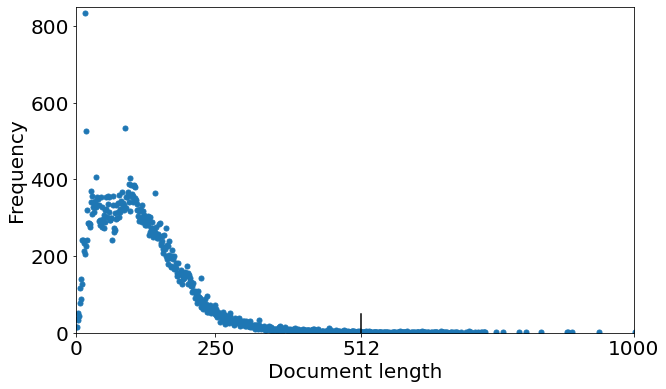

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lengths, frequencies, 'o', markersize=5)
ax.set_xlim(left=0, right=1000)
ax.set_ylim(top = 850, bottom=0)
ax.set_xticks([0, 250, 512, 1000])
ax.set_xticklabels([0, 250, 512, 1000])
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xlabel("Document length")
ax.set_ylabel("Frequency")
ax.plot([512, 512], [0, 50], 'k-')
# ax.plot(z, color='black', label='Cosine wave')

plt.savefig('doc-length-distribution.png')
plt.show()

58


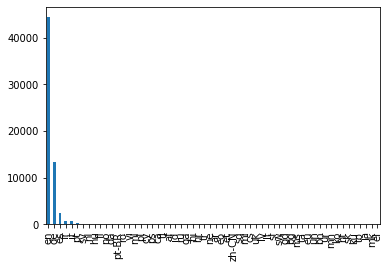

In [ ]:
language_counts = items_enriched['language'].value_counts()
language_counts.plot(kind='bar')
print(len(language_counts))

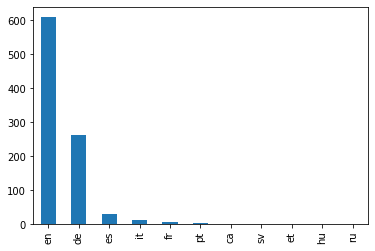

In [ ]:
evaluation_items_enriched['language'].value_counts().plot(kind='bar')

FM       5783
YFB      4118
FL       4047
YFA      3883
YFH      3499
         ... 
UDBS        1
YPCK9       1
XAB         1
YBLM        1
JBCT1       1
Name: main topic, Length: 493, dtype: int64


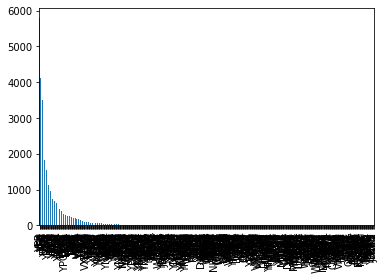

In [ ]:
print(items_enriched['main topic'].value_counts())
items_enriched['main topic'].value_counts().plot(kind='bar')

## Compute Embeddings

### Encode

In [ ]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')

In [ ]:
encodings = tokenizer.batch_encode_plus(list(items_enriched['description'].values), 
                                        truncation=True, padding="max_length", return_tensors="pt")
save_as_pickle(encodings, encodings_path)

In [ ]:
encodings = load_pickle(encodings_path)

In [ ]:
print(encodings['input_ids'].size())

torch.Size([62345, 512])


### Apply Model

In [ ]:
# model = BertModel.from_pretrained('bert-base-uncased')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, boundaries=None):
    if boundaries is not None:
      self.encodings = {key: val[boundaries[0]: boundaries[1]] for key, val in encodings.items()}
    else:
      self.encodings = encodings

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      return item

  def __len__(self):
      return len(self.encodings['input_ids'])

# dataset = Dataset(encodings, (0, 1000))
# dataset = Dataset(encodings)
# print(len(dataset))
# dataset.__getitem__(10)

In [ ]:
trainer = Trainer(
    model = model
)

In [ ]:
def get_embeddings(dataset):
  prediction_output = trainer.predict(dataset)
  results = prediction_output.predictions[1]
  del prediction_output
  torch.cuda.empty_cache()
  gc.collect()
  return results

In [ ]:
subset_size = 1000

In [ ]:
for i in range(1000, len(encodings['input_ids']), subset_size):
  print(i)
  sub_dataset = Dataset(encodings, (i-subset_size, i))
  embedding_array = get_embeddings(sub_dataset)
  path = full_project_drive_folder + f'descriptions/embeddings/{i-subset_size}-{i}.pkl'
  save_as_pickle(embedding_array, path)
  print('saved', path)
  del sub_dataset
  del embedding_array
  torch.cuda.empty_cache()
  gc.collect()

In [ ]:
# rests
lower = 62000
upper = len(encodings['input_ids'])
sub_dataset = Dataset(encodings, (lower, upper))
embedding_array = get_embeddings(sub_dataset)
path = full_project_drive_folder + f'descriptions/embeddings/{lower}-{upper}.pkl'
save_as_pickle(embedding_array, path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [ ]:
print(embedding_array.shape)

(345, 768)


### Combine Results

In [ ]:
embedding_arrays = [load_pickle(join(embeddings_folder, f)) for f in listdir(embeddings_folder) 
                                                              if load_pickle(join(embeddings_folder, f)).shape[1] == 768]
embeddings = np.concatenate(embedding_arrays)
save_as_pickle(embeddings, embeddings_path)

In [12]:
embeddings = load_pickle(embeddings_path)

In [13]:
embeddings.shape

(62345, 768)

## Recommend Amazon Data

### Load Data

In [ ]:
# amazon_test = pd.read_csv(amazon_test_path)
# amazon_val = pd.read_csv(amazon_val_path)
# amazon_val = amazon_val.merge(item_indexes, on='itemID', how='left')
# items_enriched_index is null if item is not in enriched data set (which contains descriptions)
# amazon_val.info()

In [ ]:
internal_amazon = load_pickle(internal_amazon_path)

In [ ]:
amazon_item_ids_df = pd.DataFrame.from_dict({'itemID': list(internal_amazon.keys())})
amazon_item_ids_df = amazon_item_ids_df.merge(item_indexes, how='left')
amazon_item_indexes = {int(row['itemID']): int(row['item_index']) if not np.isnan(row['item_index']) else None
                                  for idx, row in amazon_item_ids_df.iterrows()}
len(amazon_item_indexes)

232

### Enrich Internal File with Recommendations

In [14]:
scaler = MinMaxScaler()

In [ ]:
for idx, (item_id, sim_df) in enumerate(internal_amazon.items()):

  print(f'{datetime.datetime.now()} {idx+1}/{len(internal_amazon)}')
  embedding_index = amazon_item_indexes[item_id]
  
  # if embedding_index is none there is no description and therefore no embedding -> skip this and set np.nan
  if embedding_index:
    # compute cosine values and normalize
    cosine_similarity_matrix = cosine_similarity(embeddings[embedding_index,:].reshape(1, -1), embeddings)
    similarities = scaler.fit_transform([[sim] for sim in cosine_similarity_matrix[0]])
    similarities = [sim[0] for sim in similarities]

    # merge bert similarity values with existing similarities from other methods
    item_ids = [items_enriched.iloc[idx]['itemID'] for idx, sim in enumerate(cosine_similarity_matrix[0])]
    bert_df = pd.DataFrame.from_dict({'bert': similarities, 'itemID': item_ids})
    sim_df_merged_bert = sim_df.merge(bert_df, on='itemID', how='left')

  # set then to np.nan
  else:
    sim_df_merged_bert['bert'] = np.nan
  
  internal_amazon[item_id] = sim_df_merged_bert

In [ ]:
save_as_pickle(internal_amazon, internal_amazon_path)

## Recommend evaluation.csv

In [15]:
evaluation_item_ids_df = pd.DataFrame.from_dict({'itemID': list(evaluation_items['itemID'].values)})
evaluation_item_ids_df = evaluation_item_ids_df.merge(item_indexes, how='left')
evaluation_item_indexes = {int(row['itemID']): int(row['item_index']) if not np.isnan(row['item_index']) else None
                                  for idx, row in evaluation_item_ids_df.iterrows()}

In [16]:
evaluation_results = evaluation_items.copy()
evaluation_results.set_index('itemID', drop=True, inplace=True)
evaluation_results.info()
evaluation_results = evaluation_results.reindex(columns=list(items_enriched['itemID'].values))
evaluation_results.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 12 to 41078
Empty DataFrame

(1000, 62345)

In [17]:
scaler = MinMaxScaler()

for i, (itemID, row) in enumerate(evaluation_results.iterrows()):

  print(f'{datetime.datetime.now()} {i+1}/{len(evaluation_results)}')
  embedding_index = evaluation_item_indexes[itemID]

  # if no embedding_index is found there is no embedding and therefore no description
  if embedding_index:
    cosine_similarity_matrix = cosine_similarity(embeddings[embedding_index,:].reshape(1, -1), embeddings)
    similarities = scaler.fit_transform([[sim] for sim in cosine_similarity_matrix[0]])
    similarities = [sim[0] for sim in similarities]
    evaluation_results.loc[itemID] = similarities

2021-06-05 07:23:30.105103 1/1000
2021-06-05 07:23:30.589620 2/1000
2021-06-05 07:23:31.057661 3/1000
2021-06-05 07:23:31.431462 4/1000
2021-06-05 07:23:31.431663 5/1000
2021-06-05 07:23:31.885325 6/1000
2021-06-05 07:23:32.355477 7/1000
2021-06-05 07:23:32.724287 8/1000
2021-06-05 07:23:33.196749 9/1000
2021-06-05 07:23:33.197405 10/1000
2021-06-05 07:23:33.197668 11/1000
2021-06-05 07:23:33.197915 12/1000
2021-06-05 07:23:33.679568 13/1000
2021-06-05 07:23:34.050402 14/1000
2021-06-05 07:23:34.522321 15/1000
2021-06-05 07:23:34.897720 16/1000
2021-06-05 07:23:35.358262 17/1000
2021-06-05 07:23:35.823962 18/1000
2021-06-05 07:23:36.195938 19/1000
2021-06-05 07:23:36.670631 20/1000
2021-06-05 07:23:37.137379 21/1000
2021-06-05 07:23:37.508134 22/1000
2021-06-05 07:23:37.974099 23/1000
2021-06-05 07:23:38.433685 24/1000
2021-06-05 07:23:38.802850 25/1000
2021-06-05 07:23:39.264519 26/1000
2021-06-05 07:23:39.624227 27/1000
2021-06-05 07:23:40.074863 28/1000
2021-06-05 07:23:40.536218 29

In [18]:
# add columns for books which have no description
books_without_desc = list(set(items['itemID'].values) - set(items_enriched['itemID'].values))
evaluation_results = evaluation_results.reindex(columns=list(evaluation_results.columns) + books_without_desc)

In [19]:
len(list(evaluation_results.columns) + books_without_desc)

93715

In [ ]:
evaluation_results.shape

(1000, 78030)

In [20]:
evaluation_results.head(5)

,21310,19194,40250,34217,14576,17731,58723,33976,62433,72603,11989,11117,15581,44815,63847,3106,4283,54393,23197,57800,11525,12143,42285,41198,43845,62630,5368,46998,2253,52878,26528,30953,72543,13855,65634,59843,71896,56766,65865,12633,...,65427,65428,65429,65434,65441,32677,65447,32681,65449,32686,32693,65467,32700,65468,32708,65477,32710,65478,32712,65479,65480,65488,65489,32722,32725,65497,32730,32739,32741,65511,32746,65515,32752,65520,65521,65526,32759,65528,32763,32764
itemID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,0.987519,0.985037,0.992294,0.992504,0.993679,0.986267,0.992962,0.991584,0.989471,0.991891,0.993229,0.991696,0.988956,0.991803,0.995750,0.996177,0.992909,0.988621,0.991102,0.993216,0.980295,0.993894,0.992449,0.991280,0.990991,0.989914,0.990525,0.995769,0.993106,0.992128,0.996426,0.986549,0.990864,0.993198,0.989227,0.989582,0.989757,0.991481,0.992844,0.991404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45274,0.996157,0.993314,0.995141,0.995428,0.997496,0.996622,0.995408,0.993931,0.994831,0.993759,0.994686,0.996635,0.996996,0.996581,0.994100,0.994037,0.995655,0.995572,0.995914,0.994209,0.994683,0.995642,0.996365,0.996392,0.997267,0.997004,0.992838,0.995502,0.993248,0.997243,0.994047,0.994308,0.994919,0.994120,0.995725,0.995419,0.996002,0.993997,0.994932,0.993353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10104,0.995760,0.995513,0.995680,0.995878,0.996934,0.995694,0.996311,0.994445,0.994799,0.994696,0.995050,0.996099,0.996020,0.996557,0.994700,0.994276,0.996479,0.996430,0.997013,0.995323,0.993352,0.995333,0.996447,0.995801,0.996262,0.996385,0.993455,0.996173,0.992732,0.996399,0.994643,0.993991,0.994898,0.994686,0.994739,0.994962,0.994614,0.994047,0.995202,0.994026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14015,0.989579,0.987758,0.992852,0.992956,0.993000,0.986443,0.992288,0.992957,0.991888,0.992168,0.993443,0.990700,0.990749,0.991740,0.994831,0.994093,0.990618,0.990082,0.990937,0.993165,0.982279,0.994289,0.991592,0.993372,0.991971,0.991979,0.993143,0.994276,0.993480,0.991718,0.994881,0.988394,0.992812,0.994717,0.992320,0.992849,0.992631,0.993833,0.993156,0.994247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# save_as_pickle(evaluation_results, evaluation_recommendation_matrix_filename)
evaluation_results.to_csv(evaluation_recommendation_matrix_filename_csv ,sep='\t')